In [306]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [307]:
df=pd.read_csv("AI Echo.csv")
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,########,Review title 1,"Not satisfied, many bugs and issues.",1,user1,80,6,Amazon,zh,Kenya,2.1.4,No
1,########,Review title 2,Amazing quality and user-friendly interface.,5,user2,180,5,Flipkart,zh,France,1.2.3,No
2,########,Review title 3,"Terrible experience, needs major improvements.",2,user3,154,5,Flipkart,pt,USA,1.2.3,No
3,########,Review title 4,Poor performance and not user-friendly.,1,user4,96,5,Amazon,es,Qatar,2.1.4,Yes
4,########,Review title 5,"Not satisfied, many bugs and issues.",2,user5,139,6,Website,ar,Kenya,2.1.4,No


In [308]:
#1. Data Understanding and Inspection
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               500 non-null    object
 1   title              500 non-null    object
 2   review             500 non-null    object
 3   rating             500 non-null    int64 
 4   username           500 non-null    object
 5   helpful_votes      500 non-null    int64 
 6   review_length      500 non-null    int64 
 7   platform           500 non-null    object
 8   language           500 non-null    object
 9   location           500 non-null    object
 10  version            500 non-null    object
 11  verified_purchase  500 non-null    object
dtypes: int64(3), object(9)
memory usage: 47.0+ KB


In [309]:
df.isnull().sum()

date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length        0
platform             0
language             0
location             0
version              0
verified_purchase    0
dtype: int64

In [310]:
df.duplicated().sum()

np.int64(0)

In [311]:
df.shape

(500, 12)

In [312]:
#2 Data Cleaning & Preprocessing
df = df.dropna(subset=['review', 'rating'])
df.reset_index(drop=True, inplace=True)


In [313]:
df.fillna({
    'platform': 'Unknown',
    'location': 'Unknown',
    'language': 'Unknown',
    'version': 'Unknown',
    'verified_purchase': 'No'
}, inplace=True)

In [314]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [315]:
df = df.dropna(subset=['date'])

In [316]:
df['review_length'] = df['review'].astype(str).str.len()


In [317]:
#NLP STEPS
!pip install nltk


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [318]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to C:\Users\Sneha
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sneha
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [319]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_text(text):
    text = text.lower()                      # convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)     # remove special characters
    words = text.split()                     # split into words
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]  # remove stopwords
    return " ".join(words)                   # join words back


In [320]:
df['clean_review'] = df['review'].apply(clean_text)


In [321]:
#feature engineering
def sentiment_label(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['rating'].apply(sentiment_label)


In [322]:
#encode target variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])


In [323]:
# 3 Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

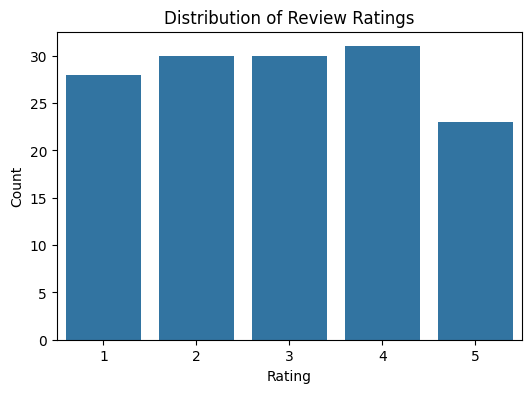

In [ ]:
#1 Distribution of Ratings (1–5)
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


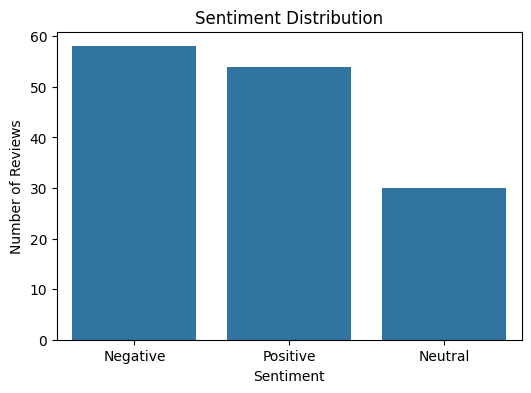

In [325]:
#Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


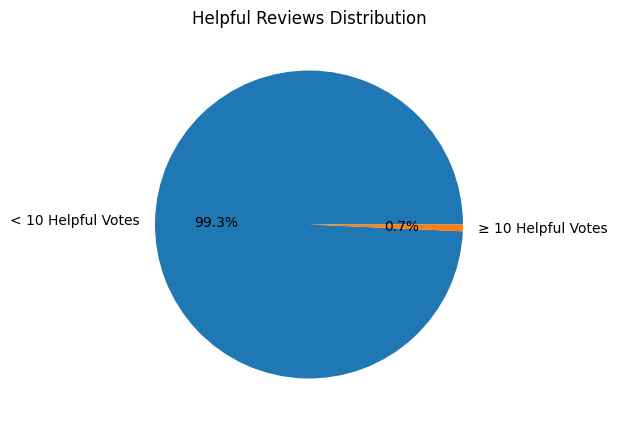

In [349]:
#2. Helpful Reviews (Threshold > 10)
threshold = 10
helpful_counts = (df['helpful_votes'] >= threshold).value_counts()

helpful_counts.plot(
    kind='pie',
    labels=['< 10 Helpful Votes', '≥ 10 Helpful Votes'],
    autopct='%1.1f%%',
    figsize=(5,5)
)
plt.title('Helpful Reviews Distribution')
plt.ylabel('')
plt.show()


In [351]:
!pip install wordcloud


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


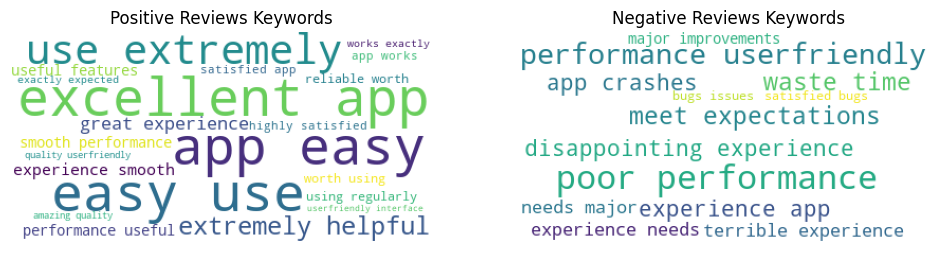

In [352]:
#3. Keywords in Positive vs Negative Reviews
from wordcloud import WordCloud

positive_text = ' '.join(df[df['rating'] >= 4]['clean_review'])
negative_text = ' '.join(df[df['rating'] <= 2]['clean_review'])

wc = WordCloud(background_color='white', max_words=200)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(wc.generate(positive_text))
plt.title('Positive Reviews Keywords')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wc.generate(negative_text))
plt.title('Negative Reviews Keywords')
plt.axis('off')

plt.show()



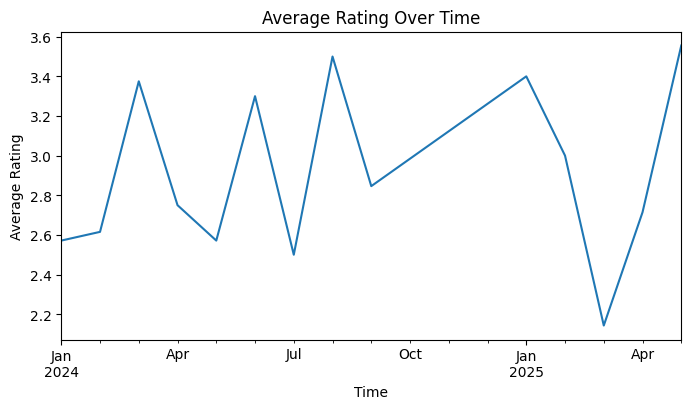

In [353]:
#4. Average Rating Over Time
df['date'] = pd.to_datetime(df['date'], errors='coerce')

rating_trend = df.groupby(df['date'].dt.to_period('M'))['rating'].mean()

rating_trend.plot(figsize=(8,4))
plt.title('Average Rating Over Time')
plt.xlabel('Time')
plt.ylabel('Average Rating')
plt.show()


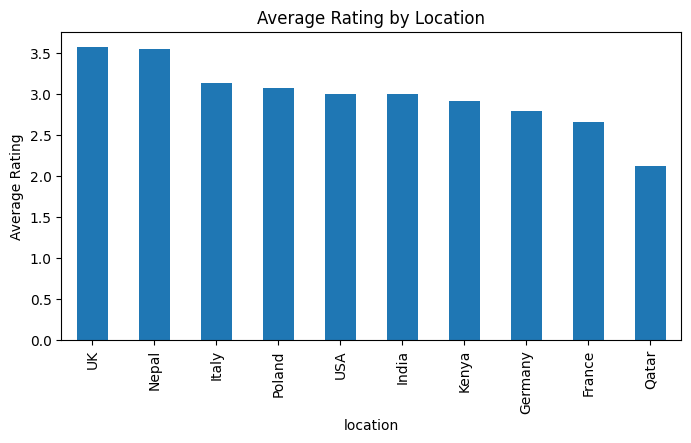

In [354]:
#5. Ratings by User Location
location_rating = df.groupby('location')['rating'].mean().sort_values(ascending=False)

location_rating.plot(kind='bar', figsize=(8,4))
plt.title('Average Rating by Location')
plt.ylabel('Average Rating')
plt.show()



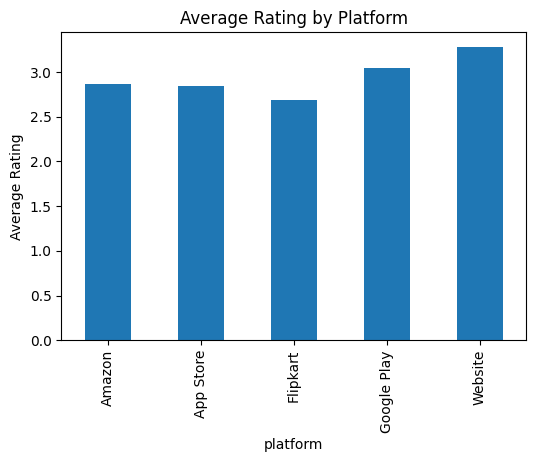

In [355]:
#6. Platform-wise Rating Comparison
platform_rating = df.groupby('platform')['rating'].mean()

platform_rating.plot(kind='bar', figsize=(6,4))
plt.title('Average Rating by Platform')
plt.ylabel('Average Rating')
plt.show()




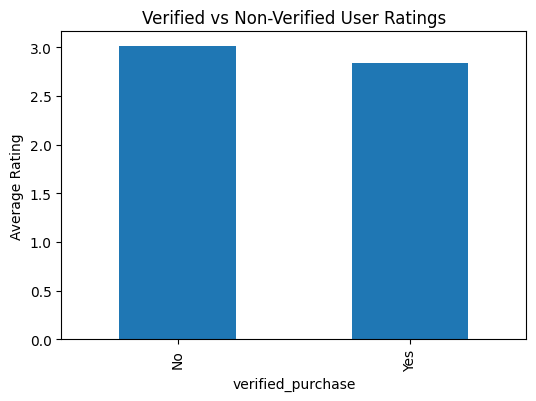

In [356]:
#7. Verified vs Non-Verified Users
verified_rating = df.groupby('verified_purchase')['rating'].mean()

verified_rating.plot(kind='bar', figsize=(6,4))
plt.title('Verified vs Non-Verified User Ratings')
plt.ylabel('Average Rating')
plt.show()


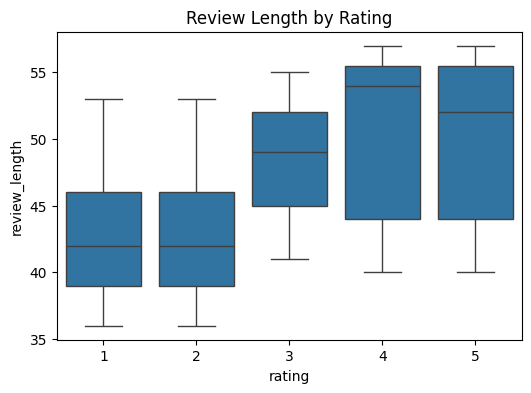

In [357]:
#8. Review Length vs Rating
df['review_length'] = df['review'].apply(len)

plt.figure(figsize=(6,4))
sns.boxplot(x='rating', y='review_length', data=df)
plt.title('Review Length by Rating')
plt.show()


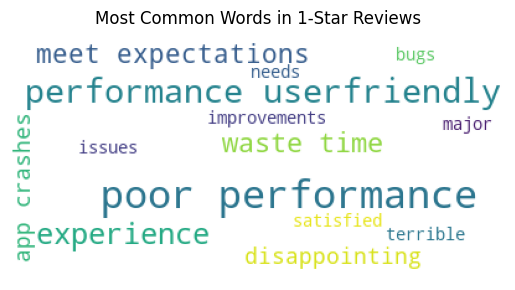

In [358]:
#9. Common Words in 1-Star Reviews
one_star_text = ' '.join(df[df['rating'] == 1]['clean_review'])

wc = WordCloud(background_color='white', max_words=150)
plt.imshow(wc.generate(one_star_text))
plt.title('Most Common Words in 1-Star Reviews')
plt.axis('off')
plt.show()


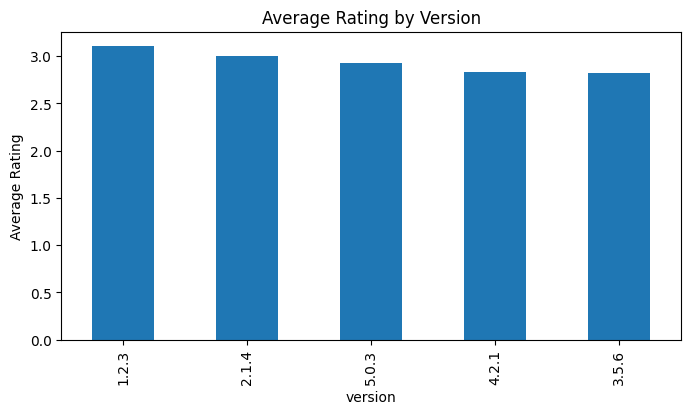

In [359]:
#10. Version-wise Average Rating
version_rating = df.groupby('version')['rating'].mean().sort_values(ascending=False)

version_rating.plot(kind='bar', figsize=(8,4))
plt.title('Average Rating by Version')
plt.ylabel('Average Rating')
plt.show()


In [331]:
#Most Common Words in Negative Reviews
from collections import Counter

negative_words = " ".join(df[df['sentiment']=='Negative']['clean_review']).split()
common_words = Counter(negative_words).most_common(10)

common_words


[('poor', 20),
 ('performance', 20),
 ('userfriendly', 20),
 ('experience', 19),
 ('waste', 14),
 ('time', 14),
 ('does', 14),
 ('meet', 14),
 ('expectations', 14),
 ('disappointing', 12)]

In [332]:
#4 Feature Extraction & Model Building
x = df['clean_review']
y = df['sentiment']  

In [333]:
df['sentiment'].value_counts()


sentiment
Negative    58
Positive    54
Neutral     30
Name: count, dtype: int64

In [334]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [335]:
#Feature Extraction using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)


In [336]:
#Model Building – Logistic Regression
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression(max_iter=1000)
lr.fit(x_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [337]:
#make predictions
y_pred = lr.predict(x_test_tfidf)

In [338]:
#Model Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [339]:
#accuracy
lr_accuracy= accuracy_score(y_test, y_pred)
print(f"Accuracy: {lr_accuracy:.2f}")

Accuracy: 1.00


In [340]:
#classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        18
     Neutral       1.00      1.00      1.00         6
    Positive       1.00      1.00      1.00        19

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



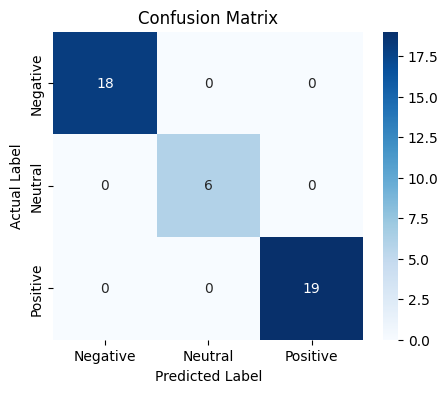

In [341]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lr.classes_,
            yticklabels=lr.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()


In [342]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf.fit(x_train_tfidf, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [343]:
y_pred_rf = rf.predict(x_test_tfidf)


In [344]:
#accuracy
rf_accuracy= accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {rf_accuracy:.2f}")

Accuracy: 1.00


In [345]:
#classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        18
     Neutral       1.00      1.00      1.00         6
    Positive       1.00      1.00      1.00        19

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



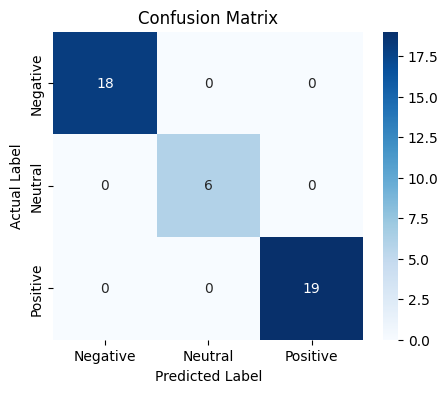

In [346]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf.classes_,
            yticklabels=rf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [347]:
#model comparison
model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy]
})

model_results


,Model,Accuracy
0,Logistic Regression,1.0
1,Random Forest,1.0


In [348]:
#saved models
import joblib
joblib.dump(lr, 'logistic_regression_model.joblib')
joblib.dump(rf, 'random_forest_model.joblib')

['random_forest_model.joblib']